# Connect-Four: Informed and Adversial Search Strategies

**PROBLEM FORMULATION**

    - Initial State: empty board (7x6); this is represented by a matrix full of 0's
    - Objective: to have a column, line or diagonal with 4 equal pieces next to each other (the pieces are represented by X's and O's, depending on the player)
    - Operators: place_piece(); place a piece in a given column

In [1]:
import time
import random
import heapq
import copy
import itertools
import pandas as pd
from collections import defaultdict
from typing import List, Literal, Tuple, Callable, Dict
from typing_extensions import Self
from dataclasses import dataclass, field
from logging import error, info, basicConfig, INFO
from math import sqrt, log

basicConfig(
    level=INFO,
    format="%(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

---

### **Board Implementation**:
This class implements the game Connect-four

In [2]:
@dataclass
class Board:
    num_rows: int #y
    num_cols: int #x
    grid: List[int]
    curr_player: int
    score: float
    last_move : List[int]
    num_pieces: int

    def __init__(
        self,
        num_rows: int,
        num_cols: int,
        curr_player: int = 1,
        grid: List[int] = [],
        score: float = 0,
        last_move: List[int] = [-1, -1], 
    ) -> None:
        self.num_rows, self.num_cols = num_rows, num_cols
        self.curr_player = curr_player
        self.grid = grid or Board.initial_board(num_rows, num_cols)
        self.score = score
        self.last_move = last_move
        self.num_pieces = num_cols*num_rows - 4
        
        assert len(self.grid) == self.num_rows * self.num_cols
    
    def __eq__(self,other:Self):
        """
        checks if two boards are equal
        """
        if self.num_cols != other.num_cols or self.num_rows != other.num_rows or self.curr_player != other.curr_player:
            return False
        x = zip(self.grid,other.grid)
        for (i,j) in x:
            if i!=j:
                return False
        return True
    
    @staticmethod
    def initial_board(num_rows: int, num_cols: int) -> List[int]:
        """
        Returns an empty board
        """
        return [0 for _ in range(num_cols * num_rows)] #initial state is the empty board
    
        """0.......0
           .........
           0.......0"""

    #to use in a dictionary (if needed)
    def __hash__(self):
        return hash((tuple(self.grid), self.curr_player))

    def is_valid_pos(self, x: int, y: int) -> bool:
        """
        Bounds check
        """
        return 0 <= x < self.num_cols and 0 <= y < self.num_rows
    
    def get_valid_actions(self) -> List[int]:
        """
        Get all actions for the current player
        """
        res = []
        i = 0
        for column in self.grid[0:self.num_cols]:
            #an action is valid if there's at least one empty slot in a given column (it's not full)
            if(column == 0):
                res.append(i)
            i += 1
                
        return res

    def get_piece(self, x: int, y: int) -> int:
        """
        Returns piece at x, y
        """
        #if piece isn't within boundaries, returns error
        if not self.is_valid_pos(x, y):
            raise IndexError(f"No such piece x:{x} y:{y}")
        return self.get_piece_unchecked(x, y)

    def get_piece_unchecked(self, x: int, y: int) -> int:
        """
        Returns piece at x, y without bounds check
        Use at your own risk
        """
        return self.grid[(y * self.num_cols) + x]

    def set_piece(self, x: int, y: int, val: int) -> None:
        """
        Sets piece at x, y to value x
        """
        if not self.is_valid_pos(x, y) or self.get_piece_unchecked(x, y) != 0:
            raise IndexError(f"No such piece x:{x} y:{y}")
        self.set_piece_unchecked(x, y, val)

    def set_piece_unchecked(self, x: int, y: int, val: int) -> None:
        """
        Sets piece at x, y to value x without bounds check
        Use at your own risk
        """
        self.grid[(y * self.num_cols) + x] = val

    def place_piece(self, x: int) -> Tuple[int ,int]:
        """
        Places a piece in column 'x'
        """
        assert self.grid[x] == 0, f"Tried to place a piece in column {x} which is already full"

        y = self.fall_piece(x)
        self.set_piece(x, y, self.curr_player)
        self.curr_player = 3 - self.curr_player
        self.num_pieces -= 1

        self.last_move = [x, y]
        return (x, y)

    def is_terminal_piece(self, x: int, y: int) -> bool:
        """
        Returns whether this is a winning/draw piece
        """
        if self.num_pieces == 0:
            return True
        
        # Diagonal \ (up -> bottom)
        count = 1
        for offset in range(-3, 4): #checks the 3 positions before, and the 3 positions after
            if offset == 0: continue

            cur_x = x + offset
            cur_y = y + offset
            if self.is_valid_pos(cur_x, cur_y) and self.get_piece_unchecked(cur_x, cur_y) == self.curr_player:
                count += 1
                if count >= 4: return True
            else:
                count = 1
        if count >= 4: return True

        # Diagonal / (bottom -> up)
        count = 1
        for offset in range(-3, 4):
            if offset == 0: continue

            cur_x = x + offset
            cur_y = y - offset
            if self.is_valid_pos(cur_x, cur_y) and self.get_piece_unchecked(cur_x, cur_y) == self.curr_player:
                count += 1
                if count >= 4: return True
            else:
                count = 1
        if count >= 4: return True

        # Horizontal -
        count = 1
        for offset in range(-3, 4):
            if offset == 0: continue

            cur_x = x + offset
            cur_y = y
            if self.is_valid_pos(cur_x, cur_y) and self.get_piece_unchecked(cur_x, cur_y) == self.curr_player:
                count += 1
                if count >= 4: return True
            else:
                count = 1
        if count >= 4: return True

        # Vertical |
        count = 1
        for offset in range(-3, 4):
            if offset == 0: continue

            cur_x = x
            cur_y = y + offset
            if self.is_valid_pos(cur_x, cur_y) and self.get_piece_unchecked(cur_x, cur_y) == self.curr_player:
                count += 1
                if count >= 4: return True
            else:
                count = 1
        
        return count >= 4
    

    def is_terminal_move(self, x: int) -> bool:
        """
        Returns whether this is a winning/draw move
        """
        y = self.fall_piece(x)
        return self.is_terminal_piece(x, y)
    
    def get_result(self) -> int:
        """
        Returns the winning player
        0: Draw
        1: player 1 wins
        2: player 2 wins

        Only call this function if 'is_terminal_move' returned TRUE
        """
        if self.num_pieces == 0:
            return 0
        return 3 - self.curr_player

    def fall_piece(self, x: int) -> int:
        """
        Return the row where the piece would fall
        """
        y = 0
        #given a row, the objective is finding the last row empty (piece is "falling")
        while y  < self.num_rows and self.get_piece(x, y) == 0:
            y += 1
        
        return y - 1

    def __str__(self) -> str:
        """
        write board
        """
        x = self.num_cols
        y = self.num_rows

        icons = ["-", "X", "O"]
        matrix = [[icons[self.get_piece(i, j)] for i in range(x)] for j in range(y)]

        ret = ""
        for row in matrix:
            ret += " ".join(map(str, row)) + "\n"

        ret += " ".join(str(x + 1) for x in range(self.num_cols))
        # ret += f"next player: {self.curr_player}"
        return ret


In [ ]:
# Test terminal move
test_cases = [
    # Diagonal \
    ([
        0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), False),
    ([
        0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), True),
    ([
        0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), False),
    ([
        0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), False),
    ([
        0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), True),
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0,
    ], (4, 2), True),

    # Diagonal /
    ([
        0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), False),
    ([
        0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), True),
    ([
        0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), False),
    ([
        0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), False),
    ([
        0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), True),
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), True),

    # Horizontal
    ([
        0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 1), True),
    ([
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 1), True),
    ([
        0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (3, 1), False),

    # Vertical
    ([
        0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (1, 2), True),
    ([
        0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ], (2, 2), False),
    ]

passed = True
for i, test in enumerate(test_cases):
    board = Board(6, 7, grid=test[0])
    if board.is_terminal_piece(test[1][0], test[1][1]) != test[2]:
        passed = False
        error(f"Test case {i} failed!\n" 
            + str(board) 
            + "\nx: " + str(test[1][0]) 
            + ", y: " + str(test[1][1]))
if passed: info("All tests passed")

In [ ]:
# Test place piece
test_cases = [
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
    ],
    [
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
    ], 0),
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
    ],
    [
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0,
    ], 0),
    ]

passed = True
for i, test in enumerate(test_cases):
    board = Board(6, 7, grid=test[0])
    board.place_piece(test[2])
    if not all(x == y for x, y in zip(board.grid, test[1])):
        passed = False
        error(f"Test case {i} failed!\n" 
            + "Expected:\n" + str(test[1])
            + "\nGot:\n" + str(board.grid))

if passed: info("All tests passed")

---

### **Game Implementation:**

In [3]:
@dataclass
class GameStats:
    """
    This is the result of a batch of games
    """
    results: List[int]
    turns_remaining: List[int]
    elapsed: float
    games_played: int

    p1_name: str
    p2_name: str

    def win_ratio1(self) -> float:
        return self.results[0] / self.games_played

    def win_ratio2(self) -> float:
        return self.results[1] / self.games_played

    def __str__(self) -> str:
        turns_avg = sum(self.turns_remaining) / self.games_played

        ret = ""
        ret += f"\n=== Elapsed time: {self.elapsed:.2f} seconds ===\n"
        ret += f"  Matches played: {self.games_played}\n"
        ret += "\n"
        ret += f"  {self.p1_name}: {self.results[0]} victories\n"
        ret += f"  {self.p2_name}: {self.results[1]} victories\n"
        ret += f"  Draws: {self.results[2]}\n"
        ret += f"  Win ratio (player 1): {self.win_ratio1():.2f}\n"
        ret += f"  Win ratio (player 2): {self.win_ratio2():.2f}\n"
        ret += "\n"
        ret += f"  Turns remaining MIN: {min(self.turns_remaining)}\n"
        ret += f"  Turns remaining MAX: {max(self.turns_remaining)}\n"
        ret += f"  Turns remaining AVG: {turns_avg:.2f}\n"
        # ret += "\n"
        # ret += f"  AVG time per game: {self.elapsed/self.games_played:.2f} s\n"
        # ret += f"  AVG time per turn: {self.elapsed/sum(self.turns_remaining):.2f} s\n"

        ret += "===============================\n"
        return ret


In [4]:
@dataclass
class Game:
    """
    Holds the game settings
    """

    state: Board
    player1_AI: Callable[[Board], int]
    player2_AI: Callable[[Board], int]

    player1_AI_name: str = "Player 1"
    player2_AI_name: str = "Player 2"

    def start(self, log_mov=False) -> int:
        """
        Start a new game
        """
        self.state = Board(self.state.num_rows, self.state.num_cols)


        result = -1
        while True:
            if self.state.curr_player == 1:
                move = self.player1_AI(self.state)
            else:
                move = self.player2_AI(self.state)


            is_terminal = self.state.is_terminal_move(move)
            self.state.place_piece(move)


            if log_mov:
                print(f"Player {3 - self.state.curr_player} placed: {move + 1}")
                print(self.state)
                print()

            if is_terminal:
                result = self.state.get_result()
                break


        return result

    def run_n_matches(self, n: int, max_time: int = 3600, log_moves: bool = False) -> GameStats:
        """
        utility function to automate n matches execution
        returns the total distribution of players wins and draws
        """
        start_time = time.time()

        results = [0, 0, 0]  # [player 1 victories, player 2 victories, draws]

        turns = []
        remaining = n
        while remaining > 0 and time.time() - start_time < max_time:
            remaining -= 1
            result = self.start(log_moves)
            results[result - 1] += 1
            turns.append(self.state.num_pieces)

        # Statistics
        elapsed = time.time() - start_time
        return GameStats(results, turns, elapsed, n-remaining, self.player1_AI_name, self.player2_AI_name)
        # --------------------------------------------------#

---

## A* Algorithm

In [5]:
@dataclass
class Node:
    board: Board
    next_move: int
    g: float
    f: float
    ancestor: int

    def __lt__(self, n2: Self):
        # A*, one node is 'better' than the other when it has a lower f cost.
        # tiebreak on smaller g
        return (self.f < n2.f) or (self.f == n2.f and self.g < n2.g)
    

In [6]:
stats = defaultdict(int)

In [7]:
def execute_a_star_move(
    h: Callable[[Board, int], float]
) -> Callable[[Board], int]:
    def execute_a_star_move_aux(start_board: Board) -> int:
        player = start_board.curr_player
        to_visit: List[Node] = []
        for move in start_board.get_valid_actions():
            if start_board.is_terminal_move(move):
                # We win so we dont need to search any further
                return move

            node = Node(start_board, move, 0, -h(start_board, move) if player == 1 else h(start_board, move), move)
            heapq.heappush(to_visit, node)

        visited = set()
        expand_me = None
        while len(to_visit) != 0:
            # Pop the best node off the to_visit list (+ goal check)
            expand_me = to_visit[0]
            if expand_me.board.is_terminal_move(expand_me.next_move):
                if expand_me.board.curr_player == player:
                    # We reached the goal
                    break
                else:
                    # The enemy wins D-:
                    heapq.heappop(to_visit)
                    visited.add((expand_me.board, expand_me.next_move))
                    continue

            visited.add((expand_me.board, expand_me.next_move))

            new_board = copy.deepcopy(expand_me.board)
            new_board.place_piece(expand_me.next_move)

            stats["a*_nodes_expanded"] += 1
            moves = new_board.get_valid_actions()
            heapq.heappop(to_visit)

            # Add each neighbour
            for move in moves:
                if (new_board, move) in visited:
                    continue

                cost = 16 # TODO: customizable?
                g = expand_me.g + cost

                idx = index_of(to_visit, new_board, move)
                if idx == -1:
                    node = Node(new_board, move, g, g - h(new_board, move) if player == 1 else g + h(new_board, move), expand_me.ancestor)
                    heapq.heappush(to_visit, node)
                else:
                    node = to_visit[idx]
                    if g < node.g:
                        node.f += g - node.g
                        node.g = g
                        node.ancestor = expand_me.ancestor
                        heap_repair(to_visit, idx)

        stats["a*_to_visit_size"] += len(to_visit)
        assert expand_me, f"Board has no valid actions {start_board}"
        return expand_me.ancestor

    return execute_a_star_move_aux

def index_of(nodes: List[Node], board: Board, move: int) -> int:
    for i, x in enumerate(nodes):
        if x.next_move == move and x.board == board:
            return i
    return -1

def heap_repair(list: List[Node], ii: int):
    while True:
        parent = (ii + 1) // 2 - 1
        if parent < 0:
            break
        if not list[ii] < list[parent]:
            break
        list[ii], list[parent] = list[parent], list[i]
        ii = parent

**Heuristic:** adds new score to last board score

In [8]:
def next4(grid: Board, move: int, pos: int, present: bool, vecs: Tuple[int, int]) -> float:
    scores = [0,1,10,50,512]
    
    x = move + pos*vecs[0]
    x0 = move
    y = grid.fall_piece(x0) + pos*vecs[1]
    y0 = grid.fall_piece(x0)
    if not grid.is_valid_pos(x, y):
        return 0
    player = grid.curr_player
    num_of_1=0
    num_of_2=0

   
    for i in range(4):
        if not grid.is_valid_pos(x, y):
            return 0
        if (x == x0 and y == y0):
            if present:
                if grid.curr_player == 2:
                    num_of_2 += 1
                else:
                    num_of_1 += 1
            
        if grid.get_piece_unchecked(x, y) == 2:
            num_of_2+=1
        if grid.get_piece_unchecked(x, y) == 1:
            num_of_1+=1
        x -= vecs[0]
        y -= vecs[1]
    
    
    if num_of_1 >0 and num_of_2>0:   
        return 0
    if num_of_1< num_of_2:
        return -1*scores[num_of_2]
    return scores[num_of_1]
               

def calc(grid: Board, move: int, present: bool) -> float:
    '''present diz se peça existe ou não'''
    x = move
    y = grid.fall_piece(x)
    player = grid.curr_player
    
    count = 0
    
    '''calcular movs (diag traz*2, esquerda, cima) * 4'''
    vecs = [(-1, -1), (-1, 0), (-1, 1), (0, 1)]
    for ve in range(4):
        for pos in range(4):
            if grid.is_valid_pos(x + pos*vecs[ve][0], y + pos*vecs[ve][1]):
                count += next4(grid, move, pos, present, vecs[ve])

    return count


def heuristic(grid: Board, move: int) -> float:
    grid.score += calc(grid, move, True) - calc(grid, move, False)
    return grid.score

**Heuristic 2:** counts the new board score from scratch

In [9]:
def heuristic2(grid: Board, move: int) -> float:

    to_remove = grid.place_piece(move)

    scores = [0,1,10,50,512]

    final_count = 0
    #jogador 1: adicionar
    #jogador 2: retirar

    for x in range(0,grid.num_cols): #x->col
        for y in range(grid.num_rows): #y->row

            #check vertically (only goes down)
            count = 0
            adv_count = 0
            for offset in range (0,4):
                cur_y = y + offset
                if grid.is_valid_pos(x, cur_y) and grid.get_piece_unchecked(x, cur_y) == 1:
                    count +=1
                elif grid.is_valid_pos(x,cur_y) and grid.get_piece_unchecked(x, cur_y) == 2:
                    adv_count +=1
            if adv_count != 0 and count != 0: #mixed X's and O's
                continue
            else:
                #print("acrescent count")
                final_count += scores[count]
                final_count -= scores[adv_count]

            #check horizontally (to the right)
            count = 0
            adv_count = 0
            for offset in range(0,4):
                cur_x = x + offset
                if grid.is_valid_pos(cur_x, y) and grid.get_piece_unchecked(cur_x, y) == 1:
                    count +=1
                elif grid.is_valid_pos(cur_x, y) and grid.get_piece_unchecked(cur_x, y) == 2:
                    adv_count +=1
            if adv_count != 0 and count != 0: #mixed X's and O's
                continue
            else:
                final_count += scores[count]
                final_count -= scores[adv_count]

            #check diagonally (right to left, down->up) /
            count = 0
            adv_count = 0
            for offset in range(0,4):
                cur_x = x + offset
                cur_y = y - offset
                if grid.is_valid_pos(cur_x, cur_y) and grid.get_piece_unchecked(cur_x, cur_y) == 1:
                    count +=1
                elif grid.is_valid_pos(cur_x, cur_y) and grid.get_piece_unchecked(cur_x, cur_y) == 2:
                    adv_count +=1
            if adv_count != 0 and count != 0: #mixed X's and O's
                continue
            else:
                final_count += scores[count]
                final_count -= scores[adv_count]

            #check diagonally (left to right, up->down) \
            count = 0
            adv_count = 0
            for offset in range(0,4):
                cur_x = x + offset
                cur_y = y + offset
                if grid.is_valid_pos(cur_x, cur_y) and grid.get_piece_unchecked(cur_x, cur_y) == 1:
                    count +=1
                elif grid.is_valid_pos(cur_x, cur_y) and grid.get_piece_unchecked(cur_x, cur_y) == 2:
                    adv_count +=1
            if adv_count != 0 and count != 0: #mixed X's and O's
                continue
            else:
                final_count += scores[count]
                final_count -= scores[adv_count]

    grid.set_piece_unchecked(to_remove[0], to_remove[1], 0)
    grid.curr_player = 3 - grid.curr_player
    grid.num_pieces += 1

    bonus = 16 if 3 - grid.curr_player == 1 else -16
    return final_count + bonus

In [ ]:
'''
test_cases = [
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0,
        2, 0, 2, 2, 2, 0, 0,
    ], -31, [2, 3], -97),

    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        2, 0, 2, 2, 2, 0, 0,
    ], -11, [2, 5], -67),

    '''
test_cases = [
    ([
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0,
    ], -123, [2, 5], -162),
]
move=5
passed = True
for i, test in enumerate(test_cases):
    board = Board(6, 7, 1, test[0], test[1], test[2])
    score = heuristic2(board,move)
    if score  != test[3]:
        passed = False
        error(f"Test case {i} failed!\n"
            + "Expected:\n" + str(test[3])
            + "\nGot:\n" + str(score))

if passed: info("All tests passed")


In [ ]:
grid = [
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        2, 0, 2, 2, 0, 0, 0,
    ]
board = Board(6, 7, 1, grid, 11)
print(board)


stats = defaultdict(int)
a_star = execute_a_star_move(heuristic2)
move = a_star(board)

print()
print("Decision:", move)
board.place_piece(move)
print(board)

print()
print(stats)

---


In [10]:
def human_move(board: Board) -> int:
    print(end="", flush=True)

    move = int(input("Jogada: ")) - 1
    while move not in board.get_valid_actions():
        print("try again", flush=True)
        move = int(input("Jogada: ")) - 1

    return move


In [11]:
def random_move(board: Board) -> int:
    return random.choice(board.get_valid_actions())

---

In [ ]:
test_game = Game(Board(6,7), random_move, execute_a_star_move(heuristic2))
result = test_game.run_n_matches(1, log_moves=True)
print(result)

In [ ]:
test_game = Game(Board(6,7), random_move, execute_a_star_move(heuristic))
test_game.run_n_matches(100, log_moves=False)

In [ ]:
"""board = Board(6, 7)
while True:
    move = int(input())
    board.place_piece(move)
    print(board)
    print("Score:", heuristic2(board,move))"""

---

## MONTE CARLO  

In [12]:
@dataclass
class MctsNode:
    board: Board
    move: int
    parent: Self | None
    children: List[Self] = field(default_factory=list)
    wins: int = 0
    visits: int = 0

In [13]:
def execute_mcts_move(
    h: Callable[[Board ,int], float], timeout: float = 10
) -> Callable[[Board], int]:
    def execute_mcts_move_aux(start_board: Board) -> int:
        playing_as = start_board.curr_player

        num_start = 0
        nodes: List[MctsNode] = []
        for move in start_board.get_valid_actions():
            if start_board.is_terminal_move(move):
                # We win so we dont need to search any further
                return move

            num_start += 1
            nodes.append(MctsNode(start_board, move, None, visits=1))

        i = 0
        start_time = time.time()
        while time.time() < start_time + timeout:
            # Select
            selected_node = select(nodes, num_start + i)

            if selected_node.board.is_terminal_move(selected_node.move):
                # Game ended
                back_propagate(selected_node.board.curr_player == playing_as, selected_node)
                i += 1
                continue
            
            child = expand(selected_node, nodes, h)
            result = simulate(child)
            back_propagate(result == playing_as, child)

            stats["mcts_rounds"] += 1
            stats["mcts_nodes"] = len(nodes)
            i += 1

        return max(nodes[:num_start], key=lambda n: n.wins / n.visits).move

    return execute_mcts_move_aux

def select(nodes: List[MctsNode], root_visits) -> MctsNode:
    return max(nodes, key=lambda n: ucb(n, root_visits))

C = 13 # This number was found by trial and error against human test subjects
def ucb(node: MctsNode, root_visits: int) -> float:
    return node.wins / node.visits + C * sqrt(2*log(node.parent.visits if node.parent else root_visits) / node.visits)

def expand(node: MctsNode, nodes: List[MctsNode], h: Callable[[Board, int], float]) -> MctsNode:
    new_board = copy.deepcopy(node.board)
    new_board.place_piece(node.move)
    moves = new_board.get_valid_actions()
    if len(moves) == len(node.children):
        # All children have been expanded
        # Choose random
        move = random.choice(moves)
    else:
        # Choose the next best child
        move = sorted(moves, key=lambda m: h(new_board, m), reverse=True)[len(node.children)]
    if (i := contains(node.children, move)) >= 0:
        return node.children[i]
    new_node = MctsNode(new_board, move, node)
    nodes.append(new_node)
    node.children.append(new_node)
    return new_node

def simulate(node: MctsNode) -> int:
    board = copy.deepcopy(node.board)
    move = node.move
    while not board.is_terminal_move(move):
        board.place_piece(move)
        move = random.choice(board.get_valid_actions())
    board.place_piece(move)
    return board.get_result()

def back_propagate(did_win: bool, node: MctsNode | None) -> None:
    while node:
        node.wins += did_win
        node.visits += 1
        node = node.parent
    
def contains(list: List[MctsNode], val: int) -> int:
    for i, x in enumerate(list):
        if val == x.move:
            return i
    return -1

In [ ]:
stats.clear()
test_game = Game(Board(6,7), random_move, execute_mcts_move(heuristic2, 10))
test_game.run_n_matches(1, log_moves=True)
stats

---

## Minimax

In [14]:
@dataclass
class State:
    """
    Holds the board state and history
    """

    board: Board
    history: List[Tuple[Tuple[int, int], float]] = field(default_factory=list)
    cur_hist: int = 0

    transposition_table: Dict[int, Tuple[List[int], int]] = field(
        default_factory=dict
    )

    def execute(self, action: int):
        """
        Executes a action and updates the history
        """
        del self.history[self.cur_hist :]
        piece = self.board.place_piece(action)
        self.history.append((piece, self.board.score))
        self.cur_hist += 1

    def undo(self) -> bool:
        """
        Undoes the last action and updates history
        Returns False if there was no previous action
        """
        if self.cur_hist == 0:
            return False

        self.cur_hist -= 1
        piece = self.history[self.cur_hist]
        self.board.set_piece_unchecked(piece[0][0], piece[0][1], 0)
        self.board.curr_player = 3 - self.board.curr_player
        self.board.num_pieces += 1
        self.board.score = piece[1]
        return True


In [15]:
def execute_minimax_move(
    evaluate_func: Callable[[Board, int], float], depth: int
) -> Callable[[Board], int]:
    def execute_minimax_move_aux(board: Board) -> int:
        state = State(board)

        best_moves = []
        best_eval = float("-inf")
        actions = state.board.get_valid_actions()
        if len(actions) == 1:
            # Its not as if we had an option and this can take a longggggg time
            return actions[0]

        player = state.board.curr_player
        for move in actions:
            if state.board.is_terminal_move(move):
                # We win, no need to continue search
                return move

            new_state_eval = minimax(
                state,
                move,
                depth - 1,
                float("-inf"),
                float("+inf"),
                False,
                player,
                evaluate_func,
            )
            state.undo()
            if new_state_eval > best_eval:
                best_moves = [move]
                best_eval = new_state_eval
            elif new_state_eval == best_eval:
                best_moves.append(move)

        assert len(best_moves) != 0, f"Board has no valid actions {state.board}"
        return random.choice(best_moves)

    return execute_minimax_move_aux


def minimax(
    state: State,
    move: int,
    depth: int,
    alpha: float,
    beta: float,
    maximizing: bool,
    player: int,
    evaluate_func: Callable[[Board, int], float],
) -> float:
    stats["minimax_expanded"] += 1

    if depth == 0:
        eval = evaluate_func(state.board, move) * (1 if player == 1 else -1)
        state.execute(move)
        return eval

    if result := state.board.is_terminal_move(move):
        state.execute(move)
        if result == player:
            return float("inf")
        elif result == 0:
            return 0
        return float("-inf")

    state.execute(move)
    if maximizing:
        max_eval = float("-inf")
        for move in state.board.get_valid_actions():
            eval = minimax(state, move, depth - 1, alpha, beta, False, player, evaluate_func)
            state.undo()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                stats["minimax_cuts"] += 1
                break
        return max_eval
    else:
        min_eval = float("inf")
        for move in state.board.get_valid_actions():
            eval = minimax(state, move, depth - 1, alpha, beta, True, player, evaluate_func)
            state.undo()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                stats["minimax_cuts"] += 1
                break
        return min_eval

In [ ]:
stats.clear()
test_game = Game(Board(6,7), human_move, execute_minimax_move(heuristic2, 5))
result = test_game.run_n_matches(1, log_moves=True)
print(result)
stats

In [16]:
def execute_minimax_move_with_transposition(
    evaluate_func: Callable[[Board, int], float], timeout: float = 10, max_depth: int = 999
) -> Callable[[Board], int]:
    def execute_minimax_move_aux_with_transposition(board: Board) -> int:
        state = State(board)
        transposition_table = {}

        best_moves = []
        best_eval = float("-inf")

        depth = 3
        start_time = time.time()
        while time.time() < start_time + timeout and depth < max_depth:
            actions = state.board.get_valid_actions()
            if len(actions) == 1:
                # Its not as if we had an option and this can take a longggggg time
                return actions[0]

            player = state.board.curr_player
            for move in actions: 
                if state.board.is_terminal_move(move):
                    # We win, no need to continue search
                    return move

                new_state_eval = minimax_with_transposition(
                    state,
                    transposition_table,
                    move,
                    depth - 1,
                    float("-inf"),
                    float("+inf"),
                    False,
                    player,
                    evaluate_func,
                )
                state.undo()
                if new_state_eval > best_eval:
                    best_moves = [move]
                    best_eval = new_state_eval
                elif new_state_eval == best_eval:
                    best_moves.append(move)
            depth += 1

        stats["minimax_transposition_depth"] = depth
        assert len(best_moves) != 0, f"Board has no valid actions {state.board}"
        return random.choice(best_moves)

    return execute_minimax_move_aux_with_transposition


def minimax_with_transposition(
    state: State,
    transposition_table: Dict[int, Tuple[List[int], int]],
    move: int,
    depth: int,
    alpha: float,
    beta: float,
    maximizing: bool,
    player: int,
    evaluate_func: Callable[[Board, int], float],
) -> float:
    stats["minimax_transposition_expanded"] += 1

    if depth == 0:
        eval = evaluate_func(state.board, move) * (1 if player == 1 else -1)
        state.execute(move)
        return eval

    if result := state.board.is_terminal_move(move):
        state.execute(move)
        if result == player:
            return float("inf")
        elif result == 0:
            return 0
        return float("-inf")
    
    state.execute(move)

    board_hash = hash(state.board)
    if board_hash in transposition_table:
        actions = transposition_table[board_hash]
    else:
        actions = (state.board.get_valid_actions(), 0)

    if maximizing:
        max_eval = float("-inf")
        evals = []
        for move in actions[0]:
            eval = minimax_with_transposition(
                state, transposition_table, move, depth - 1, alpha, beta, False, player, evaluate_func
            )
            state.undo()
            evals.append((move, eval))
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                stats["minimax_transposition_cuts"] += 1
                break

        evals.sort(key=lambda x: x[1], reverse=True)
        if actions[1] < depth:
            transposition_table[board_hash] = ([eval[0] for eval in evals], depth)

        return max_eval
    else:
        min_eval = float("inf")
        evals = []
        for move in reversed(actions[0]):
            eval = minimax_with_transposition(
                state, transposition_table, move, depth - 1, alpha, beta, True, player, evaluate_func
            )
            state.undo()
            evals.append((move, eval))
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                stats["minimax_transposition_cuts"] += 1
                break

        evals.sort(key=lambda x: x[1])
        if actions[1] < depth:
            transposition_table[board_hash] = ([eval[0] for eval in evals], depth)

        return min_eval

In [ ]:
stats.clear()
test_game = Game(Board(6,7), human_move, execute_minimax_move_with_transposition(heuristic2, 10))
result = test_game.run_n_matches(1, log_moves=True)
print(result)
stats

---


# Analysis

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
contenders = [
    (random_move, "Random Player"),
    (execute_a_star_move(heuristic), "A* eval_1"),
    (execute_a_star_move(heuristic2), "A* eval_2"),
    (execute_mcts_move(heuristic, 10), "MCTS (eval_1, 10s)"),
    (execute_mcts_move(heuristic2, 10), "MCTS (eval_2, 10s)"),
    (execute_minimax_move(heuristic, 5), "Minimax (eval_1, 5)"),
    (execute_minimax_move(heuristic2, 5), "Minimax (eval_2, 5)"),
    (execute_minimax_move_with_transposition(heuristic, 10), "Minimax_tt (eval_1, 10s)"),
    (execute_minimax_move_with_transposition(heuristic2, 10), "Minimax_tt (eval_2, 10s)"),
]

def tournment(contenders, against: int):
    n_matches = 10

    wins = defaultdict(int)
    draws = defaultdict(int)
    loses = defaultdict(int)

    # Play as player 2
    for other in contenders:
        p1_AI, p2_AI = contenders[against], other 

        game = Game(
            Board(6, 7), p1_AI[0], p2_AI[0], player1_AI_name=p1_AI[1], player2_AI_name=p2_AI[1]
        )
        results = game.run_n_matches(int(n_matches / 2), log_moves=False)

        wins[p2_AI[1]] += results.results[1]
        draws[p2_AI[1]] += results.results[2] + results.results[1]
        loses[p2_AI[1]] += n_matches

    # Play as player 1
    for other in contenders:
        p1_AI, p2_AI = other, contenders[against]

        game = Game(
            Board(6, 7), p1_AI[0], p2_AI[0], player1_AI_name=p1_AI[1], player2_AI_name=p2_AI[1]
        )
        results = game.run_n_matches(int(n_matches / 2), log_moves=False)

        wins[p1_AI[1]] += results.results[0]
        draws[p1_AI[1]] += results.results[2] + results.results[0]
    
    return wins, draws, loses

def draw(wins, draws, loses, title: str):
    ax = sns.barplot(loses, labeSSl="Losses", color="red", orient="h")
    sns.barplot(draws, label="Draws", color="grey", orient="h")
    sns.barplot(wins, label="Wins", color="green", orient="h")

    ax.legend()
    ax.set_title(title)

In [ ]:
wins, draws, loses = tournment(contenders, 0)
draw(wins, draws, loses, "Playing against random")

This barplot shows the number of victories each algorithm had while playing 10 games against random. As expected, almost every algorithm won every game, except for Minimax using the first heuristic function. This shows that maybe the first heuristic isn't so effective for this algorithm.

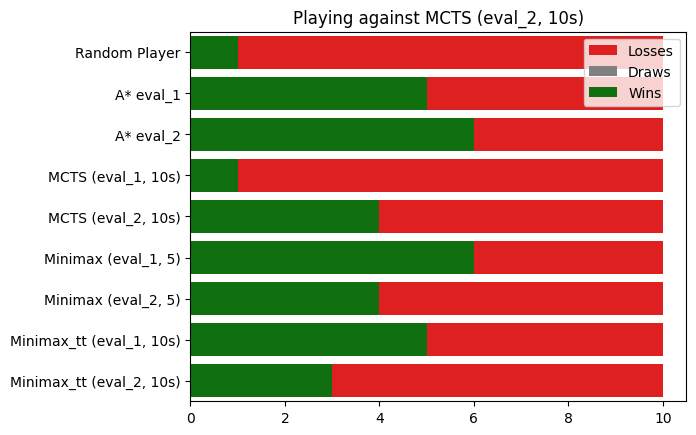

In [24]:
wins2, draws2, loses2 = tournment(contenders, 4)
draw(wins2, draws2, loses2, "Playing against MCTS (eval_2, 10s)")

The results obtained from playing 10 games against Monte Carlo Tree Search are not what was expected. 
- As this is a adversial algorithm, it should win most of the times against A* (non-adversial) , but what happened instead was a draw in the number of victories.
- As can be seen, MCTS using the first heuristic only won  only one out of the 10 games, so the second heuristic apears to be better.
- When comparing MCTS with the other adversial algorithms (MiniMax with and without transposition
), we come to the conclusion that MCTS is a little bit better, except in the case of MiniMax using the first heuristic, which is weird because this was the one which lost a game against random.

# Play against AI

In [ ]:
players = [
    (human_move, "Human"),
    (random_move, "Random"),
    (execute_a_star_move(heuristic), "A*"),
    (execute_mcts_move(heuristic, 10), "Mcts"),
    (execute_minimax_move(heuristic, 10), "Minimax"),
    (execute_minimax_move_with_transposition(heuristic, 10), "Minimax with transposition")
]

def pick_options() -> int:
    for i, (_, name) in enumerate(players):
        print(f"{i}: {name}")
    
    print(end="", flush=True)
    player = int(input())
    while player not in range(len(players)):
        player = int(input())
    return player
        

def start_game():
    print("Connect Four Extreme")
    print()

    print("Player 1:")
    player1 = players[pick_options()]
    print("")

    print("Player 2:")
    player2 = players[pick_options()]
    print("")

    game = Game(Board(6,7), player1[0], player2[0], player1[1], player2[1])
    game.start(True)

start_game()